In [5]:
import sqlite3
import pandas as pd

from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet

from tft import MyTemporalFusionTransformer
from config import get_config
from feature_creation import fc, feature_creation_every_row
from model import build_time_series_ds

config = get_config()

tft = MyTemporalFusionTransformer.load_from_checkpoint("checkpoints/5/epoch=4-val_loss=525.13.ckpt")
pred_len = config["max_pred_len"]
encoder_len = config['max_encoder_len']
embedding_labels = {v: k for k, v in tft.hparams.embedding_labels["fueltype"].items()}

/home/luke/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/luke/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [6]:
conn = sqlite3.connect("data/power_production.db")
df = pd.read_sql("SELECT * FROM power_production", conn).drop_duplicates()
conn.close()

df.rename(columns={"period": "date"}, inplace=True)
df["date"] = pd.to_datetime(df["date"])
df.sort_values(by="date", inplace=True)

df = fc(df,config['time_windows'], config["large_time_windows"])

In [7]:
PRED_START_DATE = pd.to_datetime("2024-01-15 00:00:00")
PRED_END_DATE = PRED_START_DATE  + pd.Timedelta(hours=pred_len)

In [8]:
df = df[df.date < PRED_START_DATE].loc[lambda x: x.time_idx > x.time_idx.max() - encoder_len]


encoder_data = df[lambda x: x.time_idx > x.time_idx.max() - config['max_encoder_len']]


last_data = df[lambda x: x.time_idx == x.time_idx.max()]

create a df with pred_len time steps with all of the time varying known inputs

In [9]:
week_preds = (
    pd.date_range(
        start=last_data.date.values[0] + pd.Timedelta(hours=1),
        end=last_data.date.values[0] + pd.Timedelta(hours=168),
        freq="h",
    )
    .to_series()
    .reset_index(drop=True)
    .to_frame(name="date")
    .assign(key=1)
    .merge(
        pd.DataFrame({"fueltype": last_data.fueltype.unique().tolist()}).assign(key=1),
        on="key",
    )
    .drop("key", axis=1)
)
week_preds = feature_creation_every_row(week_preds)
week_preds["time_idx"] = week_preds.date.factorize()[0] + encoder_data.time_idx.max() + 1


df["date"] = pd.to_datetime(df["date"])
week_preds["date"] = pd.to_datetime(week_preds["date"])

fill in all of the rolling columns as possible. when not possible, such as 2 hour rolling average for non-known time step, fill in that spot with data from that same time stamp from 1 year prior

In [10]:
# Create a composite key in df
df["composite_key"] = df["date"].astype(str) + "_" + df["fueltype"]

# Initialize a dictionary to hold mappings for each x in big_window_sizes
value_mappings = {}

for x in config["large_time_windows"]:
    # Compute target dates for initial and fallback searches
    week_preds[f"target_date_{x}"] = week_preds["date"] - pd.Timedelta(hours=x)
    week_preds[f"target_date_1_year_{x}"] = week_preds[
        f"target_date_{x}"
    ] - pd.DateOffset(years=1)

    # Create composite keys for initial and fallback target dates in week_preds
    week_preds[f"composite_key_{x}"] = (
        week_preds[f"target_date_{x}"].astype(str) + "_" + week_preds["fueltype"]
    )
    week_preds[f"composite_key_1_year_{x}"] = (
        week_preds[f"target_date_1_year_{x}"].astype(str) + "_" + week_preds["fueltype"]
    )

    # Create mappings from df's composite keys to values
    value_mappings[x] = df.set_index("composite_key")["value"]

# Use the mappings to find values for each x, prioritizing initial target dates over fallback dates
for x in config["large_time_windows"]:
    week_preds[f"shifted_{x}"] = week_preds[f"composite_key_{x}"].map(value_mappings[x])
    week_preds[f"shifted_1_year_{x}"] = week_preds[f"composite_key_1_year_{x}"].map(
        value_mappings[x]
    )

    # Combine initial and fallback values, prioritizing initial where available
    week_preds[f"shifted_{x}"] = week_preds[f"shifted_{x}"].fillna(
        week_preds[f"shifted_1_year_{x}"]
    )

# Cleanup: drop intermediate columns
columns_to_drop = [
    col
    for col in week_preds.columns
    if "target_date" in col or "composite_key" in col or "shifted_1_year" in col
]
week_preds.drop(columns=columns_to_drop, inplace=True)

In [68]:
new_prediction_data = pd.concat([encoder_data, week_preds], ignore_index=True).fillna(0)

#numeric_means = new_prediction_data.mean(numeric_only=True)


#new_prediction_data = new_prediction_data.fillna(numeric_means)

In [69]:
new_prediction_data

,date,fueltype,value,sin_hour,cos_hour,sin_day_week,cos_day_week,sin_day_of_year,cos_day_of_year,sin_week_year,...,rolling_type_mean_12,rolling_type_std_12,rolling_type_mean_24,rolling_type_std_24,shifted_24,shifted_48,shifted_168,shifted_730,shifted_8760,time_idx
0,2023-11-28 02:00:00,WAT,2321.0,0.500000,0.866025,0.781831,0.62349,-0.538005,0.842942,-0.781831,...,2162.166667,1467.883190,1836.791667,1285.357875,1075.0,2815.0,1009.0,521.0,673.0,39203
1,2023-11-28 02:00:00,NG,44383.0,0.500000,0.866025,0.781831,0.62349,-0.538005,0.842942,-0.781831,...,42632.333333,3281.470467,38927.791667,5166.810058,36770.0,43026.0,40637.0,32853.0,37324.0,39203
2,2023-11-28 02:00:00,COL,17138.0,0.500000,0.866025,0.781831,0.62349,-0.538005,0.842942,-0.781831,...,16895.250000,748.857448,15782.708333,1666.457933,15504.0,15928.0,12921.0,11768.0,10733.0,39203
3,2023-11-28 02:00:00,OTH,898.0,0.500000,0.866025,0.781831,0.62349,-0.538005,0.842942,-0.781831,...,1063.166667,99.678422,1055.875000,81.727709,1036.0,1064.0,1007.0,2100.0,1056.0,39203
4,2023-11-28 02:00:00,OIL,221.0,0.500000,0.866025,0.781831,0.62349,-0.538005,0.842942,-0.781831,...,220.916667,3.918681,223.791667,4.201233,222.0,222.0,89.0,93.0,184.0,39203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9403,2024-01-21 23:00:00,NG,0.0,-0.258819,0.965926,-0.781831,0.62349,0.353676,0.935368,0.433884,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,45069.0,48889.0,0.0,40378
9404,2024-01-21 23:00:00,OTH,0.0,-0.258819,0.965926,-0.781831,0.62349,0.353676,0.935368,0.433884,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1415.0,1040.0,0.0,40378
9405,2024-01-21 23:00:00,OIL,0.0,-0.258819,0.965926,-0.781831,0.62349,0.353676,0.935368,0.433884,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1223.0,231.0,0.0,40378
9406,2024-01-21 23:00:00,COL,0.0,-0.258819,0.965926,-0.781831,0.62349,0.353676,0.935368,0.433884,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,32088.0,16260.0,0.0,40378


In [64]:
_,_ ,ds = build_time_series_ds(config)

In [65]:
dsp = ds.get_parameters()

In [66]:
dsp['predict_mode'] = True

In [70]:
d = TimeSeriesDataSet.from_parameters(dsp,new_prediction_data)

In [71]:
preds = tft.predict(
    d, mode="raw", return_x=True, num_workers=32
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [72]:
df_preds = pd.DataFrame()

for x in range(8):
    values = (
        preds.output[0][x][:, 3].cpu().numpy()
    )  # [:,3] is 0.5 quantile prediction, adjust for other quantiles quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

    df_preds[x] = values

In [73]:
df_preds.rename(columns=embedding_labels, inplace=True)

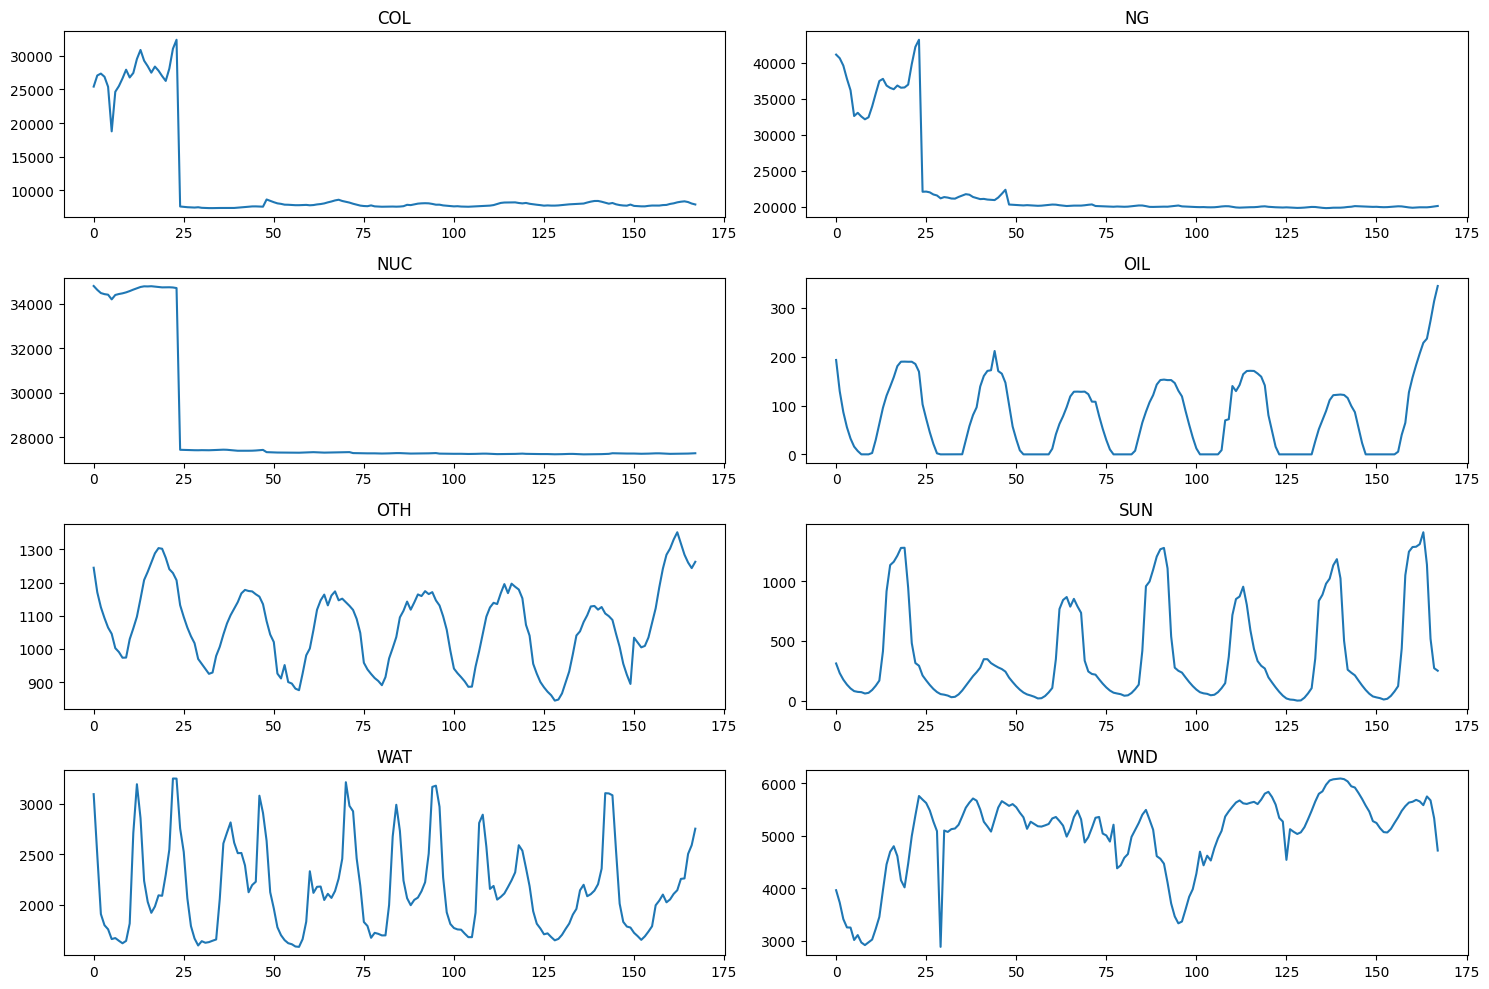

In [74]:
import matplotlib.pyplot as plt

# Set up a grid of 8 subplots (4x2)
fig, axes = plt.subplots(4, 2, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through the DataFrame's columns and create a line plot for each
for i, col in enumerate(df_preds.columns):
    axes[i].plot(df_preds[col])
    axes[i].set_title(col)

# Adjust layout for a clean look
plt.tight_layout()

# Display the plot
plt.show()

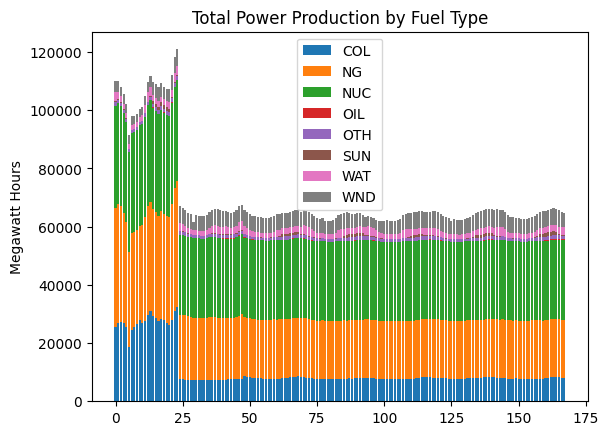

In [75]:
import numpy as np

# Create a figure and axis
fig, ax = plt.subplots()

# List of x-labels (assuming the index of df should be used)
x_labels = df_preds.index

# Plotting each category
# The bottom parameter accumulates the heights of the bars so far
bottom_accumulator = np.zeros(len(df_preds))

for column in df_preds.columns:
    ax.bar(x_labels, df_preds[column], bottom=bottom_accumulator, label=column)
    bottom_accumulator += df_preds[column].values

# Adding labels and title
# ax.set_xlabel(f"Hours since {pred_start}")
ax.set_ylabel("Megawatt Hours")
ax.set_title("Total Power Production by Fuel Type")
ax.legend()

# Display the plot
plt.show()

# true data

In [55]:
df_preds.index = pd.date_range(PRED_START_DATE, periods=len(df_preds), freq="h")

In [56]:
conn = sqlite3.connect("data/power_production.db")
df_true = pd.read_sql(
    f"SELECT * FROM power_production WHERE date >= '{str(df_preds.index.min())}' AND date <= '{str(df_preds.index.max())}'",
    conn,
).drop_duplicates()
conn.close()

df_true = df_true.pivot_table(index=["date"], columns="fueltype", values="value", aggfunc="sum").reset_index()


df_true["date"] = pd.to_datetime(df_true["date"])
df_true = df_true.drop(columns=["date"])

df_true.index = pd.date_range(PRED_START_DATE, periods=len(df_true), freq="h")

In [57]:
df_true

fueltype,COL,NG,NUC,OIL,OTH,SUN,WAT,WND
2024-01-15 00:00:00,33245.0,43401.0,33784.0,1272.0,1434.0,29.0,4144.0,3632.0
2024-01-15 01:00:00,33407.0,44951.0,33783.0,1116.0,1473.0,29.0,4293.0,3195.0
2024-01-15 02:00:00,32948.0,43940.0,33794.0,1091.0,1473.0,19.0,2051.0,3026.0
2024-01-15 03:00:00,32916.0,42004.0,33804.0,834.0,1289.0,19.0,1805.0,2573.0
2024-01-15 04:00:00,32794.0,39917.0,33790.0,845.0,1117.0,19.0,1671.0,2812.0
...,...,...,...,...,...,...,...,...
2024-01-21 19:00:00,24910.0,40259.0,33672.0,215.0,1696.0,4090.0,1153.0,5037.0
2024-01-21 20:00:00,24142.0,40462.0,33661.0,215.0,1654.0,3916.0,1498.0,5129.0
2024-01-21 21:00:00,25688.0,42221.0,33653.0,214.0,1499.0,1622.0,2329.0,5058.0
2024-01-21 22:00:00,27397.0,45206.0,33657.0,211.0,1513.0,93.0,2736.0,5172.0


In [58]:
df_preds

,COL,NG,NUC,OIL,OTH,SUN,WAT,WND
2024-01-15 00:00:00,25423.042969,41171.554688,34705.257812,194.234619,1242.929810,309.972015,3068.974609,3943.369629
2024-01-15 01:00:00,27093.146484,40674.988281,34520.277344,125.980774,1164.120972,223.380157,2466.971680,3697.758057
2024-01-15 02:00:00,27379.144531,39658.105469,34366.441406,77.558914,1113.067627,161.644196,1885.590576,3376.296875
2024-01-15 03:00:00,26905.140625,37834.578125,34312.875000,40.298080,1073.677368,112.552979,1765.981445,3207.583740
2024-01-15 04:00:00,25404.699219,36238.000000,34285.488281,10.752555,1038.295532,72.581360,1715.017578,3188.997314
...,...,...,...,...,...,...,...,...
2024-01-21 19:00:00,12671.666016,20582.818359,27357.509766,279.103455,1366.257202,1421.513916,2323.350586,5545.900879
2024-01-21 20:00:00,12680.645508,20588.121094,27359.214844,287.201752,1334.544678,1168.909912,2328.315430,5701.337891
2024-01-21 21:00:00,12692.906250,20778.515625,27366.804688,321.657410,1311.976685,583.801331,2557.662354,5632.959961
2024-01-21 22:00:00,12695.814453,21050.216797,27379.761719,358.257263,1295.467163,349.151489,2638.377441,5317.716797


In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming df_true and df_preds are your DataFrames

true_values = df_true.values.flatten()
predicted_values = df_preds.values.flatten()

# Calculate MAE, MSE, RMSE, and R-squared
mae = mean_absolute_error(true_values, predicted_values)
mse = mean_squared_error(true_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(true_values, predicted_values)

true_sum = df_true.sum(axis=1)
pred_sum = df_preds.sum(axis=1)
# mae rsme and r2 for total power production
sum_mae = mean_absolute_error(true_sum, pred_sum)
sum_mse = mean_squared_error(true_sum, pred_sum)
sum_rmse = np.sqrt(sum_mse)
sum_r2 = r2_score(true_sum, pred_sum)

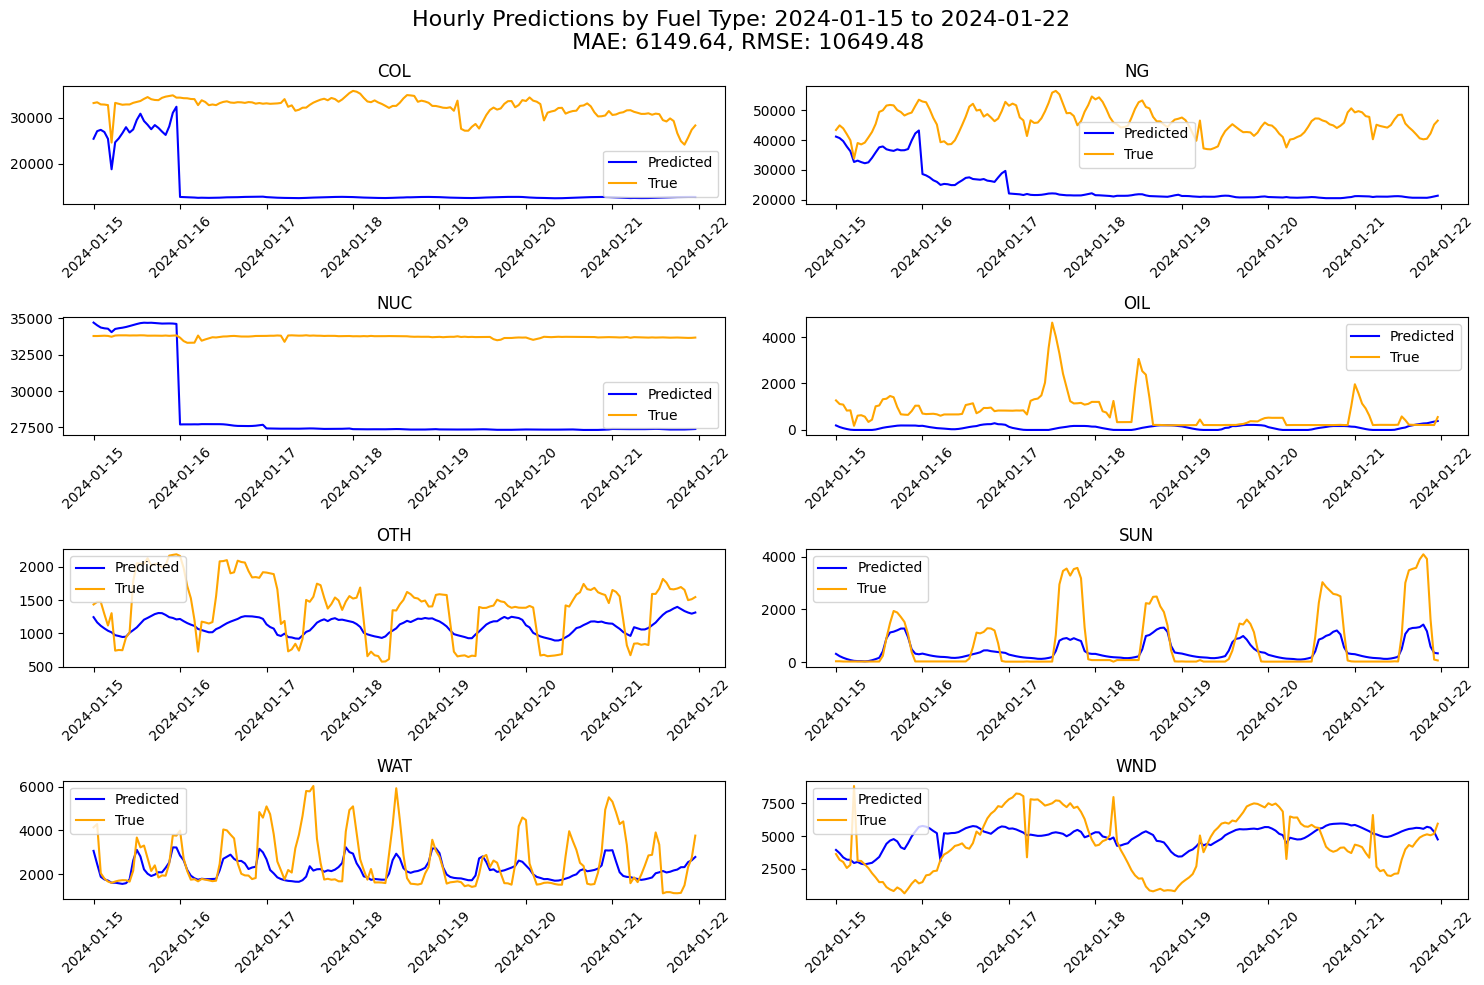

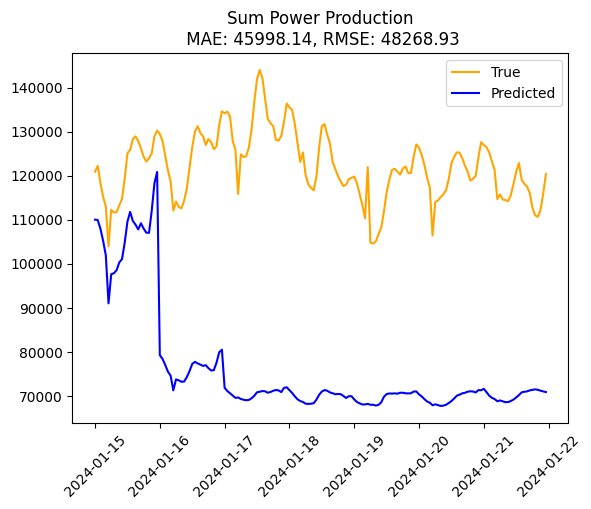

In [60]:
fig, axes = plt.subplots(
    4,
    2,
    figsize=(15, 10),
)

axes = axes.flatten()

for i, col in enumerate(df_preds.columns):
    axes[i].plot(df_preds[col], label="Predicted", color="blue")
    axes[i].plot(df_true[col], label="True", color="orange")
    axes[i].set_title(col)
    axes[i].legend()
    axes[i].xaxis.set_tick_params(rotation=45)


formatted_start_date = PRED_START_DATE.strftime("%Y-%m-%d")
formatted_end_date = PRED_END_DATE.strftime("%Y-%m-%d")

title = f"Hourly Predictions by Fuel Type: {formatted_start_date} to {formatted_end_date} \n MAE: {mae:.2f}, RMSE: {rmse:.2f}"

plt.suptitle(title, fontsize=16)

plt.tight_layout()
plt.show()

# sum plot
plt.plot(true_sum, label="True", color="orange")
plt.plot(pred_sum, label="Predicted", color="blue")
plt.title(f"Sum Power Production\n MAE: {sum_mae:.2f}, RMSE: {sum_rmse:.2f}")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [1]:
from predict import make_predictions
from config import get_config

config = get_config()

In [11]:
t, d = make_predictions(config, "2024-01-01 00:00:00", "checkpoints/5/epoch=16-val_loss=682.89.ckpt", 3)

/home/luke/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/luke/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


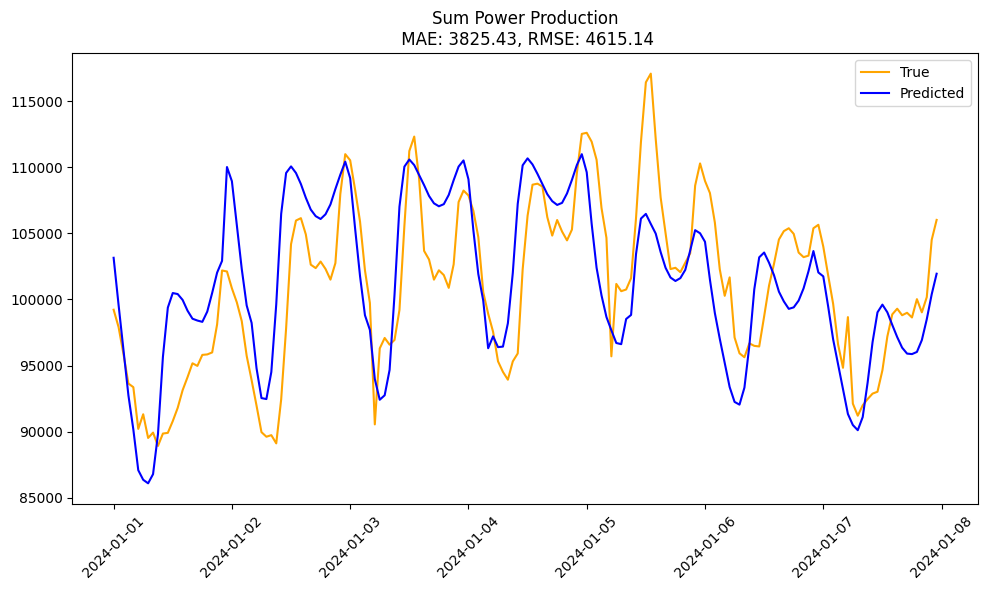

In [12]:
d

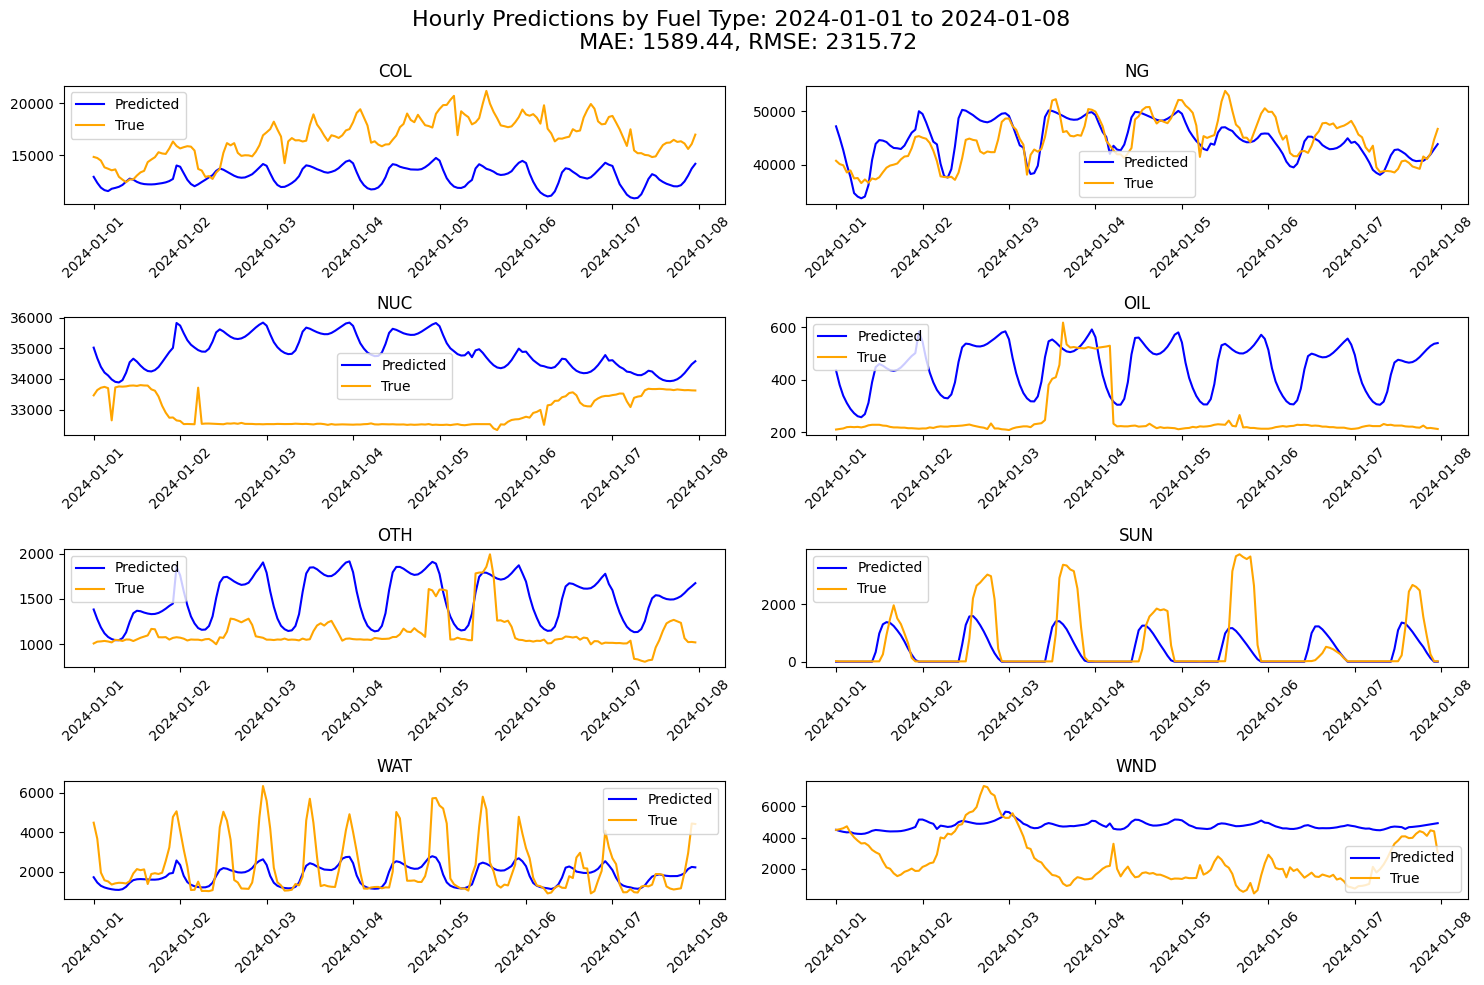

In [13]:
t